Ways to improve the results of your current backlinks checker

1. change google query to {"domain" -site: domain}  for example "quantamixsolutions.com" - site:quantamixsolutions.com
2. then analyse found links using this script to find if there is an actual backlink or not



**Metrics Info**


> Metrics are contained in a dictionary


* 'AlexaRankCountry': country name that site ranks in e.g.'United States',
*  AlexaRank: site rank in the country '8',
* 'AlexaRankCountryCode': ISO-code of the country that site ranks in e.g. 'US',
* 'AlexaReach': Alexa reach metric e.g. '11',
* 'AlexaTrafficRank': Alexa Global rank e.g. '13',
* 'anchor_text': e.g.'Here’s a table',
* 'anchor_type': it can be a text or image e.g. 'text',
* 'country': country name of the site e.g. 'France',
* 'countryCode': ISO code of country of the site' e.g. FR,
* 'externalLinks': count of external links in the backlink page e.g. 30,
* 'from_spam_heavy_country': is the site of backlink from spam-heavy country e.g. False,
* 'hasManyBacklinks': is backlink page has many external links e.g. False,
* 'ip': ipv4 address of the domain of this backlink e.g. '151.80.39.61',
* 'is_doFollow': is this a dofollow backlink e.g. True,
* 'is_exist': is backlink is actually in the page e.g. True,
* 'target_url' : the url of the page that backlink targeting on your website
* 'pagerank': page rank of domain conducted on common crawl web graph e.g. 9.54,
* 'position': link position in the html page it can be 'body', 'footer' or 'header'
* 'rank': rank for domain of backlink in common crawl web graph e.g.16,
* 'status_code': Http status code for backlink e.g. 200




In [ ]:
# !! backlink quality is evaluated on a spectrum, not a binary.
# it’s really quite rare for your site to have a link that meets more than just a couple of criteria.
# Backlink quality needs to be evaluated both on an individual level and as part of your site’s overall backlink profile.
# Existing tools that did the job already : https://kerboo.com/ , https://www.linkody.com/ , LinkResearchTools, semrush's Backlink Audit Tool , Majestic , 
#  Moz's link explorer ,Ahrefs
'''
✔️# is it a dofollow backlink ?

✔️# is it within the body of the page ? (Link location)
!!! A basic web page has 5 sections:

✔️Header
✔️Footer
Right sidebar
Left sidebar
✔️Body content
only links that appear within the body content of a page should be considered valuable to your SEO.
The higher up a page a link appears, the more important it is to the content of the page and more valuable it is to the reader
Therefore, those links will pass more value than links that occur lower in the article.


✔️# is it from a high-quality website ? we can use open pr for this!
# is it relevant to your topic in the target page ? (Linking page content relevance)

# is it using relevant keywords within the anchor text ? (Anchor text relevance)
(profile level) !!! having a link profile with nothing but keyword anchor text will likely end up hurting you more than helping.

Linking page content quality
Linking domain quality and relevance
✔️IP address

✔️Number of external links
!!! Every link on a page distributes a portion of that page’s link juice, but not all links on a page send the same amount of value. 
The amount of link juice passed by a link is equal to a page’s total link juice divided by the total number of links on a page. Including all nofollow links
a page with a lot of external links (200 or more generally) could look like a page that exists solely to sell backlinks, which will do more harm than good for SEO.
!!! the links that appear surrounding the link to your page also impact its SEO value

!!! take an especially close look for those that use the anchor text and text surrounding the links

(profile level) Ideally, your website will have a mix of anchor texts including:
1-Keyword-rich anchors
2-Just your company, website or brand name
3-Generic phrases like "click here" or “this page”.

!!! How that page fits into the overall domain also plays a factor in how much link juice it passes through backlinks.
 Orphan pages (those with no internal links pointing to them) won’t be as valuable as non-orphan pages
 because they won’t pass any of the domain’s accumulated value.

To evaluate page or domain quality, ask yourself these questions:
Does the topic of the page match the topic or niche of the overall website? 
How aggressively is the content monetized? ( Articles full of affiliate links should warn you off )
Is the site owner actually trying to help users?

(profile level) Do a lot of your links come from the same IP address? 
✔️!!! You should also look out for IP addresses from spam-heavy countries like Russia, China or India if your business doesn’t operate there.

(profile level) Is it a unique domain? ( The value of a single backlink diminishes as you acquire more links from a particular domain )
✔️How "far away" is the linking domain from Google’s trusted seed sites? 

✔️Traffic (we can use alexa metrics)
This won’t benefit your SEO all that much but still contributes to your overall marketing performance.

'''

In [ ]:
# prerequisites
!pip install requests
!pip install beautifulsoup4
!pip install geoip2
!pip install wordcloud

In [ ]:
# imports for this notebook
import matplotlib.pyplot as plt
import IPython

In [ ]:
# required modules for the script
import requests
from bs4 import BeautifulSoup
import socket
from urllib.parse import urlparse
import geoip2.database
import json
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import json
import numpy as np

In [73]:
class BacklinksAnalyser:
  def __init__(self,geoLite_db_path = None ,openprAPIKey = None):
    # get country from ip using  maxmind geoip2 @ https://github.com/maxmind/GeoIP2-python
    # !!! note you have to download GeoLite2-Country database
    # This creates a Reader object. You should use the same object
    # across multiple requests as creation of it is expensive.
    self.reader = geoip2.database.Reader(geoLite_db_path)
    self.openprAPIKey = openprAPIKey

  def get_backlink_metrics(self,backlink,targetLink):
    '''
    Get all the metrics of a certain backlink
    '''
    # backlink metrics dictionary
    metrics = {}
    target_domain = urlparse(targetLink).netloc
    backlink_domain = urlparse(backlink).netloc
    page = requests.get(backlink)
    soup = BeautifulSoup(page.text, 'html.parser')
    metrics['status_code'] = page.status_code
    metrics['backlink'] = page.url

    # Do follow vs no follow
    # check for X-Robots-Tag and robots meta tag
    xrobots = page.headers.get('X-Robots-Tag')
    metaRobots = soup.find('meta',  attrs={'name':'robots', 'content':True})
    default_follow = True
    if xrobots:  
      if "nofollow" in xrobots or "none" in xrobots :
        default_follow = False
    if metaRobots:
      if "nofollow" in metaRobots["content"] or "none" in metaRobots["content"]:
        default_follow = False

    metrics['is_doFollow'] = default_follow

    # loop through links
    metrics['is_exist'] = False
    externalCounter = 0
    for link in soup.find_all('a'):
      if link.get("href", None) == "" or link.get("href", None) is None:
        # href empty tag
        continue
      # count external links
      if backlink_domain not in link.get("href", None):
        externalCounter+=1
      # if target domain exist
      if target_domain in link.get("href", None):
        # check if it's really a backlink not just a false positive 
        if urlparse(link.get("href", None)).netloc == target_domain:
          metrics['is_exist'] = True
          metrics['target_url'] = link.get("href", None)
          metrics['position'] = 'body'
          metrics['anchor_text'] = link.string
          metrics['anchor_type'] = "text"
          if link.find('img'):
            metrics['anchor_type'] = "image"
          if link.get("rel",None) == "nofollow":
            metrics['is_doFollow'] = False
          if link.find_parent('footer'):
            metrics['position'] = 'footer'
          if link.find_parent('header'):
            metrics['position'] = 'header'
    # add external links count
    metrics['externalLinks'] = externalCounter
    metrics['hasManyBacklinks'] = externalCounter > 200
    # get Ipv4 address
    metrics['ip'] = socket.gethostbyname(backlink_domain)

    if self.reader is not None:
      # Replace "city" with the method corresponding to the database
      # that you are using, e.g., "country".
      response = self.reader.country(metrics['ip'])
      metrics['countryCode'] = response.country.iso_code
      metrics['country'] = response.country.name

      # is IP address from spam-heavy countries like Russia, China or India ?
      metrics['from_spam_heavy_country'] = False
      if metrics['country'] == "Russia" or metrics['country'] == "China" or metrics['country'] == "India":
        metrics['from_spam_heavy_country'] = True


    if self.openprAPIKey is not None:
      # is it from high authority site ? we can use either openpagerank or mozscape api
      openPR = requests.get("https://openpagerank.com/api/v1.0/getPageRank", params={'domains[]': backlink_domain},headers={"API-OPR":self.openprAPIKey})

      # convert the response 
      pr = json.loads(openPR.text)

      metrics['rank'] = pr['response'][0]['rank']
      metrics['pagerank'] = pr['response'][0]['page_rank_decimal']

    # alexa and traffic estimation
    alexa = requests.get("http://data.alexa.com/data?cli=10&url="+backlink_domain)
    soup = BeautifulSoup(alexa.text,'xml')
    popularity = soup.find("POPULARITY")
    reach = soup.find("REACH")
    rank = soup.find("COUNTRY")
    if popularity:
      metrics['AlexaTrafficRank'] =  popularity.get("TEXT",None)
    if reach:
      metrics['AlexaReach'] = reach.get("RANK",None)
    if rank:
      metrics['AlexaRank'] = rank.get("RANK",None)
      metrics['AlexaRankCountry'] = rank.get("NAME",None)
      metrics['AlexaRankCountryCode'] = rank.get("CODE",None)  

    return metrics

  @staticmethod
  def generate_analysis_summary(backlinks_df):
    '''
    generate analysis summary from backlinks dataframe
    parameters :
    backlinks_df : pandas dataframe that holds backlinks data
    returns:
    a dictionary that holds the computed analysis figures
    '''

    summary = {}

    # get the count of alive backlinks
    alive_backlinks = backlinks_df[backlinks_df['is_exist'] == True]
    summary['alive_backlinks_count'] = alive_backlinks['backlink'].count()

    # get backlinks opportunities count
    summary['backlinks_opportunities_count'] = backlinks_df.shape[0] - summary['alive_backlinks_count']

    # get http status code of backlinks
    status_code = alive_backlinks['status_code'].value_counts().to_dict()
    # make keys json vaild
    summary['status_code']  = {'http_'+str(k) : v for k, v in status_code.items()}

    # dofollow vs nofollow analysis
    link_type = alive_backlinks['is_doFollow'].value_counts().rename(index={True: "DoFollow",False : "NoFollow"})
    summary['follow_type'] = link_type.to_dict()

    # compute dofollow percentage
    summary['dofollow_percent'] = link_type['DoFollow'] / summary['alive_backlinks_count'] * 100

    # backlinks postions
    summary['postion'] = alive_backlinks['position'].value_counts().to_dict()
    
    # anchor types of backlinks
    summary['anchor_type'] = alive_backlinks['anchor_type'].value_counts().to_dict()
    
    # countries of backlinks
    countries = alive_backlinks['countryCode'].value_counts().to_dict()
    # get full names of the countries
    countries_names = {}
    for country in countries:
      countries_names[country] = alive_backlinks[alive_backlinks['countryCode'] == country]['country'].iloc[0]
    
    # create a list of countries for each backlink
    countries_info = []
    for country in countries:
      country_info = {}
      country_info['name'] = countries_names[country]
      country_info['code'] = country
      country_info['count'] = countries[country]
      countries_info.append(country_info)

    summary['countries'] = countries_info

    # add referring domain feature
    alive_backlinks['refer_domain'] = alive_backlinks['backlink'].apply(lambda x: urlparse(x).netloc)

    # get the count of unique referring domains
    summary['referring_domains_count'] = alive_backlinks['refer_domain'].unique().size
    
    # get the count of unique referring IPs
    summary['referring_ips_count'] = alive_backlinks['ip'].unique().size

    # create text for anychart tag cloud
    # Create stopword list:
    stopwords = set(STOPWORDS)
    # create text
    summary['anchor_text'] = " ".join(term for term in alive_backlinks.anchor_text if term not in stopwords and len(term) > 1)
    
    return summary

In [74]:
# backlinks analyser usage 
backlinks= [
'https://raisedtoday.com/fr/soci%C3%A9t%C3%A9/quantamix-solutions',
'https://themacmarketer.com/a-guide-to-top-10-ai-tools-and-techniques-in-seo-for-digital-marketing-quantamix-solutions',
'https://crunchbase.com/organization/quantamix-solutions',
'https://glassdoor.com/Jobs/Quantamix-Solutions-Amsterdam-Jobs-EI_IE2852604.0,19_IL.20,29_IM1112.htm',
'https://glassdoor.com/Location/Quantamix-Solutions-Uithoorn-Location-EI_IE2852604.0,19_IL.20,28_IC3065372.htm',
'https://angel.co/company/quantamix-solutions-1',
'https://oblcc.com/quantamix',
'https://zaubacorp.com/company/QUANTAMIX-SOLUTIONS-PRIVATE-LIMITED/U72200PN2019PTC181629',
'https://glassdoor.com.au/Location/All-Quantamix-Solutions-Office-Locations-E2852604.htm',
'https://commons.wikimedia.org/wiki/File:Quantamix_Solutions_Logo.png',
'https://iamexpat.nl/career/jobs-netherlands/recruitment-agencies-and-companies/quantamix-solutions-bv',
'https://graduateland.com/employer/jobs/quantamix-solutions-bv',
'https://glassdoor.sg/Reviews/Quantamix-Solutions-Reviews-E2852604.htm',
'https://europe-internship.com/employer/harish77kumar',
'https://naukri.com/recruiter-job-listings-Python-Developer-Quantamix-Solutions-Pvt-Ltd-Bengaluru-Bangalore-Pune-Jaipur-2-to-4-years-7634208',
'https://chemarc.com/companies/company_detail/quantamix-solutions-private-limited/U72200PN2019PTC181629',
'https://cleartax.in/f/company/quantamix-solutions-private-limited/U72200PN2019PTC181629',
'https://empowerednews.net/content-automation-ai-tools-market-detailed-swot-analysis-by-2027-quantamix-solutions-scoop-it-stats-llc-wordsmith-wordlift-srl/181672469',
'https://hubspot.com/agencies/growack-com',
'http://eurobankingonline.org'
]

analyser = BacklinksAnalyser('GeoLite2-Country.mmdb','so8gc48ccg8kkw04cwo04s4gcck4g8s0ck4s000k')
target_website = 'https://quantamixsolutions.com/' 

# initialize backlinks dataframe
backlinks_df = pd.DataFrame(columns=['backlink','status_code', 'is_doFollow', 'is_exist', 'target_url', 'position',
       'anchor_text', 'anchor_type', 'externalLinks', 'hasManyBacklinks', 'ip',
       'countryCode', 'country', 'from_spam_heavy_country', 'rank', 'pagerank',
       'AlexaTrafficRank', 'AlexaReach', 'AlexaRank', 'AlexaRankCountry',
       'AlexaRankCountryCode'])


In [ ]:
# populate backlinks dataframe
for backlink in backlinks:
  metrics = analyser.get_backlink_metrics(backlink,target_website)
  backlinks_df = backlinks_df.append(metrics, ignore_index = True)

In [ ]:
# save backlinks_df into csv fole
backlinks_df.to_csv('backlinks.csv',index=False)

In [75]:
# load backlinks_df from csv
backlinks_df = pd.read_csv('backlinks.csv')
backlinks_df.head()

,backlink,status_code,is_doFollow,is_exist,target_url,position,anchor_text,anchor_type,externalLinks,hasManyBacklinks,ip,countryCode,country,from_spam_heavy_country,rank,pagerank,AlexaTrafficRank,AlexaReach,AlexaRank,AlexaRankCountry,AlexaRankCountryCode
0,https://www.raisedtoday.com/fr/soci%C3%A9t%C3%...,200,True,True,https://quantamixsolutions.com/,body,\n\t\t\t\t\t\t\t\t\t\tquantamixsolutions.com/\...,text,97,False,104.24.120.60,US,United States,False,115552367,0.55,682345.0,606448.0,176382.0,India,IN
1,https://themacmarketer.com/a-guide-to-top-10-a...,200,True,True,https://quantamixsolutions.com/blog/40/ai-tool...,body,A Guide to Top 10 AI tools and techniques in S...,text,15,False,94.237.79.108,SG,Singapore,False,19583346,2.13,5726678.0,5201003.0,NaN,NaN,NaN
2,https://www.crunchbase.com/organization/quanta...,403,True,False,NaN,NaN,NaN,NaN,1,False,104.22.63.68,US,United States,False,1229,6.35,3984.0,5170.0,948.0,United States,US
3,https://www.glassdoor.com/Jobs/Quantamix-Solut...,403,True,False,NaN,NaN,NaN,NaN,0,False,104.17.91.51,US,United States,False,2022,6.15,447.0,479.0,127.0,United States,US
4,https://www.glassdoor.com/Location/Quantamix-S...,403,True,False,NaN,NaN,NaN,NaN,0,False,104.17.91.51,US,United States,False,2022,6.15,447.0,479.0,127.0,United States,US


In [ ]:
# render backlinks table
IPython.display.HTML(backlinks_df.to_html(index=False))

backlink,status_code,is_doFollow,is_exist,target_url,position,anchor_text,anchor_type,externalLinks,hasManyBacklinks,ip,countryCode,country,from_spam_heavy_country,rank,pagerank,AlexaTrafficRank,AlexaReach,AlexaRank,AlexaRankCountry,AlexaRankCountryCode
https://www.raisedtoday.com/fr/soci%C3%A9t%C3%A9/quantamix-solutions,200,True,True,https://quantamixsolutions.com/,body,\n\t\t\t\t\t\t\t\t\t\tquantamixsolutions.com/\n\t\t\t\t\t\t\t\t\t,text,97,False,104.24.120.60,US,United States,False,115552367,0.55,682345,606448,176382,India,IN
https://themacmarketer.com/a-guide-to-top-10-ai-tools-and-techniques-in-seo-for-digital-marketing-quantamix-solutions/,200,True,True,https://quantamixsolutions.com/blog/40/ai-tools-and-techniques-in-seo-for-affiliate-marketing,body,A Guide to Top 10 AI tools and techniques in SEO for Digital Marketing | Quantamix Solutions,text,15,False,94.237.79.108,SG,Singapore,False,19583346,2.13,5726678,5201003,NaN,NaN,NaN
https://www.crunchbase.com/organization/quantamix-solutions,403,True,False,NaN,NaN,NaN,NaN,1,False,104.22.63.68,US,United States,False,1229,6.35,3984,5170,948,United States,US
"https://www.glassdoor.com/Jobs/Quantamix-Solutions-Amsterdam-Jobs-EI_IE2852604.0,19_IL.20,29_IM1112.htm",403,True,False,NaN,NaN,NaN,NaN,0,False,104.17.91.51,US,United States,False,2022,6.15,447,479,127,United States,US
"https://www.glassdoor.com/Location/Quantamix-Solutions-Uithoorn-Location-EI_IE2852604.0,19_IL.20,28_IC3065372.htm",403,True,False,NaN,NaN,NaN,NaN,0,False,104.17.91.51,US,United States,False,2022,6.15,447,479,127,United States,US
https://angel.co/company/quantamix-solutions-1,403,False,False,NaN,NaN,NaN,NaN,1,False,104.18.24.39,US,United States,False,10550,5.71,6197,7161,2574,United States,US
https://oblcc.com/quantamix,200,True,False,NaN,NaN,NaN,NaN,19,False,198.49.23.145,US,United States,False,3118963,3.46,NaN,NaN,NaN,NaN,NaN
https://www.zaubacorp.com/company/QUANTAMIX-SOLUTIONS-PRIVATE-LIMITED/U72200PN2019PTC181629,200,True,False,NaN,NaN,NaN,NaN,27,False,13.235.181.248,IN,India,True,255974,4.48,6479,6258,527,India,IN
https://www.glassdoor.com.au/Location/All-Quantamix-Solutions-Office-Locations-E2852604.htm,403,True,False,NaN,NaN,NaN,NaN,0,False,104.16.203.90,US,United States,False,838534,4.20,24755,23915,326,Australia,AU
https://commons.wikimedia.org/wiki/File:Quantamix_Solutions_Logo.png,200,True,False,NaN,NaN,NaN,NaN,80,False,208.80.154.224,US,United States,False,68,8.02,325,294,302,United States,US


In [76]:
# get summary of backlinks analysis
summary = analyser.generate_analysis_summary(backlinks_df)
summary

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'alive_backlinks_count': 2,
 'anchor_text': '\n\t\t\t\t\t\t\t\t\t\tquantamixsolutions.com/\n\t\t\t\t\t\t\t\t\t A Guide to Top 10 AI tools and techniques in SEO for Digital Marketing | Quantamix Solutions',
 'anchor_type': {'text': 2},
 'backlinks_opportunities_count': 18,
 'countries': [{'code': 'SG', 'count': 1, 'name': 'Singapore'},
  {'code': 'US', 'count': 1, 'name': 'United States'}],
 'dofollow_percent': 100.0,
 'follow_type': {'DoFollow': 2},
 'postion': {'body': 2},
 'referring_domains_count': 2,
 'referring_ips_count': 2,
 'status_code': {'http_200': 2}}

In [77]:
# convert summary to json
summary_txt = str(summary)
json_acceptable = summary_txt.replace("'", "\"")
json.dumps(json_acceptable)

'"{\\"alive_backlinks_count\\": 2, \\"backlinks_opportunities_count\\": 18, \\"status_code\\": {\\"http_200\\": 2}, \\"follow_type\\": {\\"DoFollow\\": 2}, \\"dofollow_percent\\": 100.0, \\"postion\\": {\\"body\\": 2}, \\"anchor_type\\": {\\"text\\": 2}, \\"countries\\": [{\\"name\\": \\"Singapore\\", \\"code\\": \\"SG\\", \\"count\\": 1}, {\\"name\\": \\"United States\\", \\"code\\": \\"US\\", \\"count\\": 1}], \\"referring_domains_count\\": 2, \\"referring_ips_count\\": 2, \\"anchor_text\\": \\"\\\\n\\\\t\\\\t\\\\t\\\\t\\\\t\\\\t\\\\t\\\\t\\\\t\\\\tquantamixsolutions.com/\\\\n\\\\t\\\\t\\\\t\\\\t\\\\t\\\\t\\\\t\\\\t\\\\t A Guide to Top 10 AI tools and techniques in SEO for Digital Marketing | Quantamix Solutions\\"}"'

In [58]:
# add referring domain feature
backlinks_df['refer_domain'] = backlinks_df['backlink'].apply(lambda x: urlparse(x).netloc)

In [59]:
# get the count of alive backlinks
alive_backlinks = backlinks_df[backlinks_df['is_exist'] == True]
backlinks_count = alive_backlinks['backlink'].count()
backlinks_count

2

In [60]:
# get the count of unique referring domains
referring_domains_count = alive_backlinks['refer_domain'].unique().size
referring_domains_count

2

In [61]:
# get the count of unique referring IPs
referring_ips_count = alive_backlinks['ip'].unique().size
referring_ips_count

2

In [62]:
# get backlinks opportunities count
opportunities_count = backlinks_df.shape[0] - backlinks_count
opportunities_count

18

In [63]:
# get status_code counts
status_code = alive_backlinks['status_code'].value_counts().to_dict()
status_code

{200: 2}

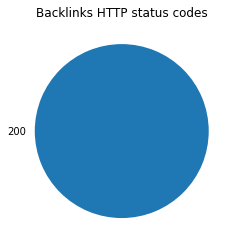

In [ ]:
alive_backlinks['status_code'].value_counts().plot(kind='pie')
plt.axis('off')
plt.title('Backlinks HTTP status codes');

In [ ]:
link_type = alive_backlinks['is_doFollow'].value_counts().rename(index={True: "DoFollow",False : "NoFollow"})
follow_type = link_type.to_dict()
follow_type

{'DoFollow': 2}

In [ ]:
# compute dofollow percentage
dofollow_percent = link_type['DoFollow'] / backlinks_count * 100
dofollow_percent

100.0

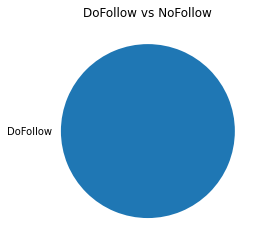

In [ ]:
link_type.plot(kind='pie')
plt.axis('off')
plt.title('DoFollow vs NoFollow');

In [ ]:
# find top pages in your site (ordered by their popularity to get backlinks)
top_pages = alive_backlinks['target_url'].value_counts().index.tolist()

In [ ]:
# render top pages table
top_pages_series = pd.Series(top_pages)
top_pages_df = pd.DataFrame({'Rank':top_pages_series.index+1,'Page URL': top_pages_series})
IPython.display.HTML(top_pages_df.to_html(index=False))

Rank,Page URL
1,https://quantamixsolutions.com/
2,https://quantamixsolutions.com/blog/40/ai-tools-and-techniques-in-seo-for-affiliate-marketing


In [ ]:
# postion of the backlinks
postion = alive_backlinks['position'].value_counts().to_dict()
postion

{'body': 2}

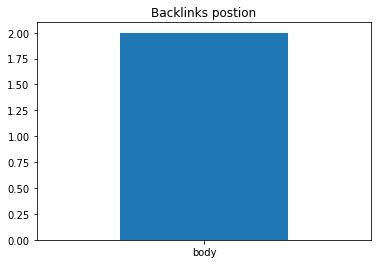

In [ ]:
# backlinks position graph
alive_backlinks['position'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Backlinks postion');

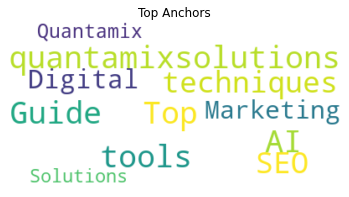

In [ ]:
# anchor text cloud graph
# use anychart tag cloud at front end @https://docs.anychart.com/Basic_Charts/Tag_Cloud
# create text
text = " ".join(term for term in alive_backlinks.anchor_text)
# Create stopword list:
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image using matplotlib way
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Top Anchors')
plt.show()

In [ ]:
# create text for anychart tag cloud
# Create stopword list:
stopwords = set(STOPWORDS)
# create text
text = " ".join(term for term in alive_backlinks.anchor_text if term not in stopwords)
text

'\n\t\t\t\t\t\t\t\t\t\tquantamixsolutions.com/\n\t\t\t\t\t\t\t\t\t A Guide to Top 10 AI tools and techniques in SEO for Digital Marketing | Quantamix Solutions'

In [ ]:
# anchor types of backlinks
anchor_type = alive_backlinks['anchor_type'].value_counts().to_dict()
anchor_type

{'text': 2}

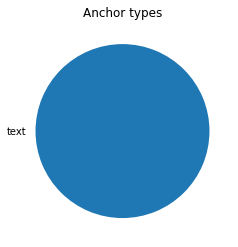

In [ ]:
# anchor types graph
alive_backlinks['anchor_type'].value_counts().plot(kind='pie')
plt.axis('off')
plt.title('Anchor types');

In [ ]:
# countries of backlinks
countries = alive_backlinks['countryCode'].value_counts().to_dict()
countries

{'SG': 1, 'US': 1}

In [ ]:
# get full names of the countries
countries_names = {}
for country in countries:
  countries_names[country] = alive_backlinks[alive_backlinks['countryCode'] == country]['country'].iloc[0]
countries_names

{'SG': 'Singapore', 'US': 'United States'}

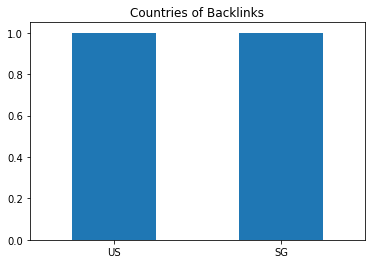

In [ ]:
# countries graph
alive_backlinks['countryCode'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Countries of Backlinks');

In [ ]:
# !!! cells bellow are from the older version of this analyer

In [ ]:
backlink = "https://ahrefs.com/blog/nofollow-links/"
targetLink = "https://en.wikipedia.org/wiki/Nofollow#Interpretation_by_the_individual_search_engines"

domain = urlparse(targetLink).netloc
backlinkDomain = urlparse(backlink).netloc

page = requests.get(backlink)
soup = BeautifulSoup(page.text, 'html.parser')

# backlink metrics dictionary
metrics = {}
metrics['status_code'] = page.status_code


In [ ]:
# Do follow vs no follow
# check for X-Robots-Tag and robots meta tag
xrobots = page.headers.get('X-Robots-Tag')
metaRobots = soup.find('meta',  attrs={'name':'robots', 'content':True})
default_follow = True
if xrobots:  
  if "nofollow" in xrobots or "none" in xrobots :
    default_follow = False
if metaRobots:
  if "nofollow" in metaRobots["content"] or "none" in metaRobots["content"]:
    default_follow = False

metrics['is_doFollow'] = default_follow

# loop through links
metrics['is_exist'] = False
externalCounter = 0
for link in soup.find_all('a'):
  if link.get("href", None) == "" or link.get("href", None) is None:
    # href empty tag
    continue
  # count external links
  if backlinkDomain not in link.get("href", None):
    externalCounter+=1
  # if target domain exist
  if domain in link.get("href", None):
    metrics['is_exist'] = True
    metrics['position'] = 'body'
    metrics['anchor_text'] = link.string
    metrics['anchor_type'] = "text"
    if link.find('img'):
      metrics['anchor_type'] = "image"
    if link.get("rel",None) == "nofollow":
      metrics['is_doFollow'] = False
    if link.find_parent('footer'):
      metrics['position'] = 'footer'
    if link.find_parent('header'):
      metrics['position'] = 'header'
# add external links count
metrics['externalLinks'] = externalCounter
metrics['hasManyBacklinks'] = externalCounter > 200
# get Ipv4 address
metrics['ip'] = socket.gethostbyname(backlinkDomain)


In [ ]:
# get country from ip using  maxmind geoip2 @ https://github.com/maxmind/GeoIP2-python

# !!! note you have to download GeoLite2-Country database

# This creates a Reader object. You should use the same object
# across multiple requests as creation of it is expensive.
reader = geoip2.database.Reader('GeoLite2-Country.mmdb')
# Replace "city" with the method corresponding to the database
# that you are using, e.g., "country".
response = reader.country(metrics['ip'])
metrics['countryCode'] = response.country.iso_code
metrics['country'] = response.country.name

# is IP address from spam-heavy countries like Russia, China or India ?
metrics['from_spam_heavy_country'] = False
if metrics['country'] == "Russia" or metrics['country'] == "China" or metrics['country'] == "India":
  metrics['from_spam_heavy_country'] = True

In [ ]:
# is it from high authority site ? we can use either openpagerank or mozscape api
openprAPIKey = "so8gc48ccg8kkw04cwo04s4gcck4g8s0ck4s000k"
openPR = requests.get("https://openpagerank.com/api/v1.0/getPageRank", params={'domains[]': domain},headers={"API-OPR":openprAPIKey})

# convert the response 
pr = json.loads(openPR.text)

metrics['rank'] = pr['response'][0]['rank']
metrics['pagerank'] = pr['response'][0]['page_rank_decimal']

In [ ]:
# alexa and traffic estimation
alexa = requests.get("http://data.alexa.com/data?cli=10&url="+domain)
soup = BeautifulSoup(alexa.text,'xml')
popularity = soup.find("POPULARITY")
reach = soup.find("REACH")
rank = soup.find("COUNTRY")
if popularity:
  metrics['AlexaTrafficRank'] =  popularity.get("TEXT",None)
if reach:
  metrics['AlexaReach'] = reach.get("RANK",None)
if rank:
  metrics['AlexaRank'] = rank.get("RANK",None)
  metrics['AlexaRankCountry'] = rank.get("NAME",None)
  metrics['AlexaRankCountryCode'] = rank.get("CODE",None)  

Alexa API response

In [ ]:
alexa.text

'<?xml version="1.0" encoding="UTF-8"?>\r\n\r\n<!-- Need more Alexa data?  Find our APIs here: https://aws.amazon.com/alexa/ -->\r\n<ALEXA VER="0.9" URL="en.wikipedia.org/" HOME="0" AID="=" IDN="en.wikipedia.org/">\r\n<SD><POPULARITY URL="wikipedia.org/" TEXT="13" SOURCE="panel"/><REACH RANK="11"/><RANK DELTA="+0"/><COUNTRY CODE="US" NAME="United States" RANK="8"/></SD></ALEXA>'

Domcop API resoponse

In [ ]:
pr

{'last_updated': '18th Jun 2020',
 'response': [{'domain': 'en.wikipedia.org',
   'error': '',
   'page_rank_decimal': 9.54,
   'page_rank_integer': 10,
   'rank': '16',
   'status_code': 200}],
 'status_code': 200}

**Final output**

In [ ]:
metrics

{'AlexaRank': '8',
 'AlexaRankCountry': 'United States',
 'AlexaRankCountryCode': 'US',
 'AlexaReach': '11',
 'AlexaTrafficRank': '13',
 'anchor_text': 'Here’s a table',
 'anchor_type': 'text',
 'country': 'France',
 'countryCode': 'FR',
 'externalLinks': 30,
 'from_spam_heavy_country': False,
 'hasManyBacklinks': False,
 'ip': '151.80.39.61',
 'is_doFollow': True,
 'is_exist': True,
 'pagerank': 9.54,
 'position': 'body',
 'rank': '16',
 'status_code': 200}

**TODO**


*   Is it a unique domain? (Conducted on profile level)
*   Do a lot of your links come from the same IP address? (Conducted on profile level)
